# How VQE on actual qcomp differs from running on simulator?

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

noise_models = []

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])



# VQE with different noise scalings

In [2]:
# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram
    

In [3]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [11]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA

# Specifying whether running code on a simulator or an actual quantum device
#load IBMQ account
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmqx2')
simulator = Aer.get_backend('qasm_simulator')
#setting up noisy sim 
noisy_sim= QuantumInstance(backend=simulator, 
                                   noise_model=noise_model )
print(noisy_sim)
# creating a list of distances to run VQE on 
exact_energy = []
vqe_real_energy = []
vqe_sim_energy = []
vqe_noisy_sim_energy = []
distances = np.arange(0.5, 1.5, 0.1)

for dist in distances:
    print('DOing distance -----====----' + str(dist)+ '----------------')
    optimizer = COBYLA(maxiter=1000)
    qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
    # Finding exact energies to show how off VQE was from exact energy curve
    result = ExactEigensolver(qubitOp).run()
    exact_energy.append(result['energy'] + shift)
    print('Exact energy is :')
    print(exact_energy[-1])
    # Initial STate 
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        'parity'
    ) 
    print('Number of qubits are : ' + str(qubitOp.num_qubits))
    # UCCSD Variational Form
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    # Running VQE 
    vqe = VQE(qubitOp, var_form, optimizer)

    #Running VQE pn actual quant comp
    print('Starting on actual')
    resulty = vqe.run(backend)['energy'] + shift
    print('Number of evaluations are')
    print(vqe._eval_count)
    vqe_real_energy.append(resulty)
    print('Done doing VQE on actual device')
    print('VQE energy is :')
    print(vqe_real_energy[-1])
    #Running VQE on good sim 
    print('Starting on good sim')
    resulti = vqe.run(simulator)['energy'] + shift
    vqe_sim_energy.append(resulti)


    #running noisy sim VQE 
    print('Starting on noisy simulator')
    energies = []
    for i in range(1):
        resulty = vqe.run(noisy_sim)['energy'] + shift
        energies.append(resulty)
    vqe_noisy_sim_energy.append(np.mean(energies))
    print('done doing vqe on noisy simulator')

print("All energies have been calculated")

ibmqfactory.load_account:WARNING:2020-06-24 21:04:56,490: Credentials are already in use. The existing account in the session will be replaced.



Qiskit Terra version: 0.14.2
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{}
{'noise_model': NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'cx', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']}
Measurement mitigation: None
DOing distance -----====----0.5----------------
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.0551597944706212
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
37
Done doing VQE on actual device
VQE energy is :
-0.9738237559717702
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----0.6----------------
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.1162860068695373
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
39
Done doing VQE on actual device
VQE energy is :
-0.9914321475978596
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----0.7----------------
HF energy: -1.8733164791617076
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.1361894540659239
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
37
Done doing VQE on actual device
VQE energy is :
-1.0617408363608813
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----0.7999999999999999----------------
HF energy: -1.7723219111265944
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.1341476666770975
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
41
Done doing VQE on actual device
VQE energy is :
-1.0801065358773299
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----0.8999999999999999----------------
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.1205602812999857
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
40
Done doing VQE on actual device
VQE energy is :
-1.0203344857890397
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----0.9999999999999999----------------
HF energy: -1.5952858602379365
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.1011503302326202
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
42
Done doing VQE on actual device
VQE energy is :
-1.0495012671131199
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----1.0999999999999999----------------
HF energy: -1.5176090667746345
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.079192944969074
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
35
Done doing VQE on actual device
VQE energy is :
-0.9921237193040354
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----1.1999999999999997----------------
HF energy: -1.44608771566849
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.0567407463052563
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
38
Done doing VQE on actual device
VQE energy is :
-1.0135195958885699
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----1.2999999999999998----------------
HF energy: -1.380170008792963
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.0351862664342537
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
40
Done doing VQE on actual device
VQE energy is :
-0.9708059091350454
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
DOing distance -----====----1.4----------------
HF energy: -1.3194643767935121
# of electrons: 2
# of spin orbitals: 4
Exact energy is :
-1.0154682492882452
Number of qubits are : 2


The skip Qobj validation does not work for IBMQ provider. Disable it.


Starting on actual
Number of evaluations are
40
Done doing VQE on actual device
VQE energy is :
-0.9776006566410458
Starting on good sim
Starting on noisy simulator
done doing vqe on noisy simulator
All energies have been calculated


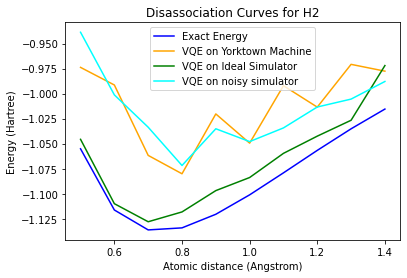

In [12]:
import matplotlib.pyplot as plt
plt.plot(distances, exact_energy, label="Exact Energy", color = 'blue')
plt.plot(distances, vqe_real_energy, label="VQE on Yorktown Machine", color = 'orange')
plt.plot(distances, vqe_sim_energy, label="VQE on Ideal Simulator", color = 'green')
plt.plot(distances, vqe_noisy_sim_energy, label = 'VQE on noisy simulator', color = 'cyan')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Disassociation Curves for H2')
plt.legend()
plt.show()

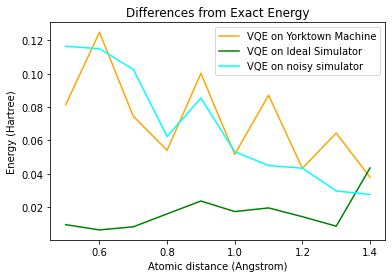

In [13]:
import matplotlib.pyplot as plt
plt.plot(distances, [vqe_real_energy[i] -exact_energy[i] for i in range(len(distances))], label="VQE on Yorktown Machine",  color = 'orange')
plt.plot(distances, [vqe_sim_energy[i] -exact_energy[i] for i in range(len(distances))], label="VQE on Ideal Simulator",  color = 'green')
plt.plot(distances, [vqe_noisy_sim_energy[i] -exact_energy[i] for i in range(len(distances))], label = 'VQE on noisy simulator', color = 'cyan')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Differences from Exact Energy')
plt.legend()
plt.show()